In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('../data/features_seattle_911_no_dup_seasonalilty.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.Datetime = pd.to_datetime(df.Datetime)

In [3]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,weekday,night,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,day_num,seasonality
0,6900 37th Av S,Medic Response,2011-11-09 23:33:00,47.540683,-122.286131,"(47.540683, -122.286131)",F110104166,11/09/2011 11:33:00 PM,2011-11-09,23:33:00,...,Wednesday,1,0,0,0,0,0,1,498,0.889486
1,N 50th St / Stone Way N,Aid Response,2011-11-09 23:32:00,47.665034,-122.340207,"(47.665034, -122.340207)",F110104164,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,Wednesday,1,0,0,0,0,0,1,498,0.889486
2,E John St / E Olive Way,Aid Response,2011-11-09 23:32:00,47.619575,-122.324257,"(47.619575, -122.324257)",F110104165,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,Wednesday,1,0,0,0,0,0,1,498,0.889486
3,611 12th Av S,Aid Response,2011-11-09 23:29:00,47.597406,-122.317228,"(47.597406, -122.317228)",F110104162,11/09/2011 11:29:00 PM,2011-11-09,23:29:00,...,Wednesday,1,0,0,0,0,0,1,498,0.889486
4,4545 42nd Av Sw,Automatic Medical Alarm,2011-11-09 23:25:00,47.562472,-122.385455,"(47.562472, -122.385455)",F110104161,11/09/2011 11:25:00 PM,2011-11-09,23:25:00,...,Wednesday,1,0,0,0,0,0,1,498,0.889486


0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000


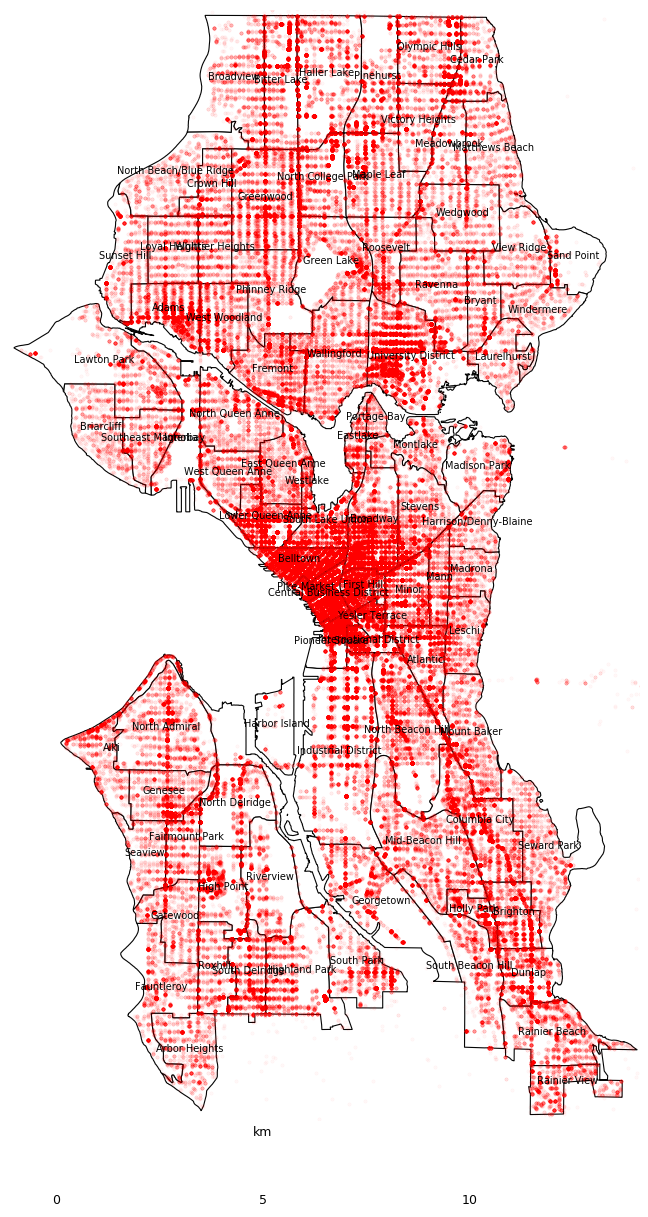

In [4]:
def plot_prepper(m, shapefilename, df_key):
    '''
    Generate dataframe for plotting
    '''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df_poly = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df_poly['centroid_1'] = cent_lons
    df_poly['centroid_2'] = cent_lats
    return _out, df_poly

# Read in neighborhood shape file
hood_shapefilename = '../neighborhoods_shape/WGS84/Neighborhoods'
hood_coords = (-122.43595589761988, 47.49551362397606, 
               -122.23604445458412, 47.73416494684497)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

# Initialize the plot
figwidth = 12
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(projection='tmerc', ellps='WGS84',
            lon_0=np.mean([hood_coords[0], hood_coords[2]]),
            lat_0=np.mean([hood_coords[1], hood_coords[3]]),
            llcrnrlon=hood_coords[0] - extra * w,
            llcrnrlat=hood_coords[1] - (extra * h),
            urcrnrlon=hood_coords[2] + extra * w,
            urcrnrlat=hood_coords[3] + (extra * h),
            resolution='i',  suppress_ticks=True)

# Get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

# Draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#050505', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
pc.set_facecolor('w')
ax.add_collection(pc)

# Scale the map
m.drawmapscale(hood_coords[0] + 0.08, hood_coords[1] + -0.01, 
               hood_coords[0], hood_coords[1], 10., barstyle='fancy',
               fillcolor1='w', fillcolor2='#555555', zorder=5, ax=ax,)

lons = df.Longitude
lats = df.Latitude

pt = []
xs = []
ys = []

'''
This plots all the latitude/longitude points
'''
for mapped_x, mapped_y in zip(lons, lats):
    xpt, ypt = m(mapped_x, mapped_y)
    plt.plot(xpt, ypt, '.', markersize=5, alpha=0.03, color='r')
    pt.append(Point(xpt, ypt))
    xs.append(xpt)
    ys.append(ypt)

Labels = []
nmlist = []

'''
Checks the neighborhood of point
'''
# Creates list of neighborhoods
for polygon in df_map['poly']:
    nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
    if len(nm.strip()) < 4 or nm in nmlist:
        continue
    nmlist.append(nm)

"""
Determines neighborhood of point
"""
for i, p in enumerate(pt):
    # Create Unknown placeholder to capture points no in a neighborhood
    Labels.append('Unknown')
    # Tracks progress
    if i % 50000 == 0:
        print i
    # Creates polygon and if pt in polygon records neighborhood name
    for j, row in df_map.iterrows():
        polygon = row['poly']
        nm = row[0]
        if polygon.contains(p):
            Labels[i] = nm

# Add neighborhood names
nml = []
for i, lon in enumerate(df_map['centroid_1'].values):
    if df_map['name'].values[i] in nml:
        continue
    nml.append(df_map['name'].values[i])
    if len(df_map['name'].values[i]) > 3:
        plt.text(lon, df_map['centroid_2'].values[i], df_map['name'].values[i], size=7, ha='center')

ax.axes.get_xaxis().set_visible(False)
#plt.savefig('../images/seattle_911_neighborhoods.png')


In [5]:
if 'Unknown' in Labels:
    print 'yes'
if 'Unknown' not in Labels:
    print 'no'

yes


In [6]:
len(Labels)

574863

In [7]:
len(df)

574863

In [8]:
len(nmlist)

90

In [9]:
len(df_map)

121

In [10]:
Labels

['Holly Park',
 'Wallingford',
 'Broadway',
 'International District',
 'Genesee',
 'Belltown',
 'Brighton',
 'South Delridge',
 'Ravenna',
 'University District',
 'East Queen Anne',
 'Haller Lake',
 'Belltown',
 'Pinehurst',
 'Roxhill',
 'Pike-Market',
 'Minor',
 'Yesler Terrace',
 'Lower Queen Anne',
 'Greenwood',
 'Central Business District',
 'Central Business District',
 'Brighton',
 'Green Lake',
 'Mount Baker',
 'Fremont',
 'Belltown',
 'Holly Park',
 'Belltown',
 'South Park',
 'Cedar Park',
 'Lower Queen Anne',
 'Stevens',
 'Fairmount Park',
 'Pioneer Square',
 'Minor',
 'South Park',
 'North Admiral',
 'Broadview',
 'Adams',
 'Alki',
 'Pioneer Square',
 'Cedar Park',
 'Bitter Lake',
 'Windermere',
 'Dunlap',
 'Pioneer Square',
 'Rainier Beach',
 'Bitter Lake',
 'South Delridge',
 'Stevens',
 'Greenwood',
 'South Lake Union',
 'Phinney Ridge',
 'Wallingford',
 'Loyal Heights',
 'North Queen Anne',
 'Bitter Lake',
 'Haller Lake',
 'North Beacon Hill',
 'Dunlap',
 'Pioneer Squa

In [11]:
df['neighborhood'] = Labels

In [12]:
zone1 = ['Sunset Hill', 'Crown Hill', 'Greenwood', 'North College Park',
         'North Beach/Blue Ridge', 'Broadview', 'Bitter Lake',
         'Haller Lake', 'Loyal Heights', 'Adams', 'Whittier Heights',
         'West Woodland', 'Phinney Ridge', 'Wallingford', 'Fremont',
         'Green Lake']

zone2 = ['Pinehurst', 'Maple Leaf', 'Wedgwood', 'Matthews Beach',
         'Meadowbrook', 'Olympic Hills', 'Cedar Park', 'Victory Heights',
         'View Ridge', 'Ravenna', 'Sand Point', 'Bryant', 'Windermere',
         'Laurelhurst', 'Roosevelt', 'University District']

zone3 = ['West Queen Anne', 'North Queen Anne', 'Eastlake', 
         'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 
         'Interbay', 'East Queen Anne']

zone4 = ['Montlake', 'Portage Bay', 'Madison Park', 'Broadway',
         'Stevens', 'Leschi', 'Madrona', 'Harrison/Denny-Blaine',
         'Minor', 'Mann', 'Atlantic', 'First Hill', 'Yesler Terrace']

zone5 = ['Pike-Market', 'International District', 
         'Central Business District', 'Pioneer Square']

zone6 = ['Belltown', 'Lower Queen Anne', 'Westlake', 'South Lake Union']

zone7 = ['Alki', 'North Admiral', 'Fairmount Park', 'Genesee',
         'Fauntleroy', 'North Delridge', 'Riverview', 'High Point',
         'South Delridge', 'Roxhill', 'Highland Park', 'Harbor Island',
         'South Park', 'Seaview', 'Gatewood', 'Arbor Heights']

zone8 = ['North Beacon Hill', 'Mid-Beacon Hill', 'South Beacon Hill',
         'Brighton', 'Dunlap', 'Rainier Beach', 'Rainier View',
         'Mount Baker', 'Columbia City', 'Seward Park', 'Georgetown',
         'Holly Park', 'Industrial District']

In [13]:
df['zone1'] = df.neighborhood.isin(zone1).astype(int)
df['zone2'] = df.neighborhood.isin(zone2).astype(int)
df['zone3'] = df.neighborhood.isin(zone3).astype(int)
df['zone4'] = df.neighborhood.isin(zone4).astype(int)
df['zone5'] = df.neighborhood.isin(zone5).astype(int)
df['zone6'] = df.neighborhood.isin(zone6).astype(int)
df['zone7'] = df.neighborhood.isin(zone7).astype(int)
df['zone8'] = df.neighborhood.isin(zone7).astype(int)

In [15]:
df.head().T

,0,1,2,3,4
Address,6900 37th Av S,N 50th St / Stone Way N,E John St / E Olive Way,611 12th Av S,4545 42nd Av Sw
Type,Medic Response,Aid Response,Aid Response,Aid Response,Automatic Medical Alarm
Datetime,2011-11-09 23:33:00,2011-11-09 23:32:00,2011-11-09 23:32:00,2011-11-09 23:29:00,2011-11-09 23:25:00
Latitude,47.5407,47.665,47.6196,47.5974,47.5625
Longitude,-122.286,-122.34,-122.324,-122.317,-122.385
Report Location,"(47.540683, -122.286131)","(47.665034, -122.340207)","(47.619575, -122.324257)","(47.597406, -122.317228)","(47.562472, -122.385455)"
Incident Number,F110104166,F110104164,F110104165,F110104162,F110104161
dt_crop,11/09/2011 11:33:00 PM,11/09/2011 11:32:00 PM,11/09/2011 11:32:00 PM,11/09/2011 11:29:00 PM,11/09/2011 11:25:00 PM
date,2011-11-09,2011-11-09,2011-11-09,2011-11-09,2011-11-09
time,23:33:00,23:32:00,23:32:00,23:29:00,23:25:00


In [14]:
df.to_csv("../data/features_seattle_911_no_dup_hoods.csv")